In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  8 14:37:46 2020

@author: Amy.Huff

"""
#Import libraries and settings

#To perform array operations
import numpy as np 

#Main plotting libraries
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

#Libaries for drawing figures and map projections
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

#Library for reading netCDF files
from netCDF4 import Dataset

#Module for manipulating dates and times
import datetime

#Library for collecting lists of files from folders
import glob

import warnings
warnings.filterwarnings('ignore')

#Sets font size to 12
plt.rcParams.update({'font.size': 12})

#Option to keep numpy from printing in scientific notation by default
np.set_printoptions(suppress = True)

In [3]:
# #File settings
# file_path = 'D://Data/2020/2020-07/20200726/VIIRS ADP/'
# file_name = 'JRR ADP_v2r1_j01_s202007262332292_e202007262333537_c202007262352470.nc'

# #Open single data file and set file name
# fname = file_path + file_name
# file_id = Dataset(fname)

##Function to select and process VIIRS ADP data, aerosol detection only (smoke and dust)
def VIIRS_ADP_Detect(file_id):
    #Select smoke pixels using the "Smoke" variable (mask pixels with smoke absent)
    #smoke present = 1, smoke absent = 0
    Smoke_Flag = file_id.variables['Smoke'][:,:]
    Smoke_Mask = (Smoke_Flag == 0)
    Smoke = np.ma.masked_where(Smoke_Mask, Smoke_Flag)
    
    #Select dust pixels using the "Dust" variable (mask pixels with dust absent)
    #dust present = 1, dust absent = 0
    Dust_Flag = file_id.variables['Dust'][:,:]
    Dust_Mask = (Dust_Flag == 0)
    Dust_Intermediate = np.ma.masked_where(Dust_Mask, Dust_Flag)
    
    #Remove dust pixels in sun-glint regions using the "PQI2" variable, bit 1 (mask pixels within sun-glint)
    34
    #outside sun-glint = 0, within sun-glint = 2
    PQI2 = file_id.variables['PQI2'][:,:]
    Glint_Mask = (PQI2 & 2 == 2)
    Dust = np.ma.masked_where(Glint_Mask, Dust_Intermediate)
    
    #Read in latitude and longitude
    Lon = file_id.variables['Longitude'][:,:]
    Lat = file_id.variables['Latitude'][:,:]

    return Smoke, Dust, Lat, Lon

##Function to select and process VIIRS ADP data, smoke/dust intensity using scaled absorbing aerosol index (SAAI)
def VIIRS_ADP_SAAI(file_id):
    #Read in the SAAI data
    SAAI = file_id.variables['SAAI'][:,:]
    
    #Select smoke pixels using the "Smoke" variable (mask pixels with smoke absent)
    #smoke present = 1, smoke absent = 0
    Smoke_Flag = file_id.variables['Smoke'][:,:]
    Smoke_Mask = (Smoke_Flag == 0)
    SAAI_Smoke = np.ma.masked_where(Smoke_Mask, SAAI)
    
    #Select deep-blue based algorithm smoke pixels using the "PQI4" variable, bits 4-5 (mask missing and IR-vis
    #based algorithm pixels)
    #missing = 16, IR-vis based algorithm = 32
    PQI4 = file_id.variables['PQI4'][:,:]
    Smoke_Algorithm_Mask = (((PQI4 & 16) + (PQI4 & 32) == 16) | ((PQI4 & 16) + (PQI4 & 32) == 32))
    SAAI_Smoke_Total = np.ma.masked_where(Smoke_Algorithm_Mask, SAAI_Smoke)
    
    #Select dust pixels using the "Dust" variable (mask pixels with dust absent)
    #dust present = 1, dust absent = 0
    Dust_Flag = file_id.variables['Dust'][:,:]
    Dust_Mask = (Dust_Flag == 0)
    SAAI_Dust = np.ma.masked_where(Dust_Mask, SAAI)
    
    #Select deep-blue based algorithm dust pixels using the "PQI4" variable, bits 6-7 (mask missing and IR-vis
    # based algorithm pixels)
    #missing = 64, IR-vis based algorithm = 128
    Dust_Algorithm_Mask = (((PQI4 & 64) + (PQI4 & 128) == 64) | ((PQI4 & 64) + (PQI4 & 128) == 128))
    35
    SAAI_Dust_Intermediate = np.ma.masked_where(Dust_Algorithm_Mask, SAAI_Dust)
    
    #Remove deep-blue algorithm dust pixels in sun-glint regions using the "PQI2" variable, bit 1 (mask pixels
    #within sun-glint)
    #outside sun-glint = 0, within sun-glint = 2
    PQI2 = file_id.variables['PQI2'][:,:]
    Glint_Mask = (PQI2 & 2 == 2)
    SAAI_Dust_Total = np.ma.masked_where(Glint_Mask, SAAI_Dust_Intermediate)
    
    #Read in latitude and longitude
    Lon = file_id.variables['Longitude'][:,:]
    Lat = file_id.variables['Latitude'][:,:]

    return SAAI_Smoke_Total, SAAI_Dust_Total, Lat, Lon

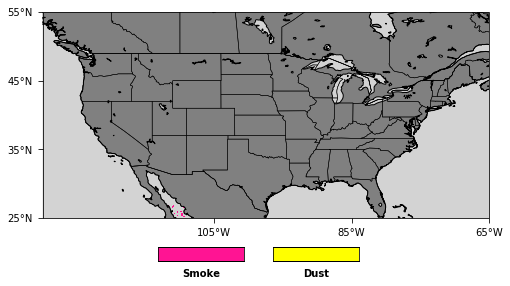

JRR-ADP_j01_2020-11-05_21:24:42


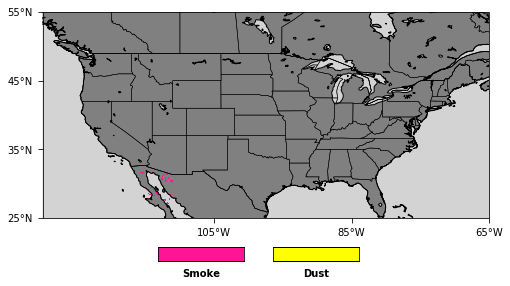

JRR-ADP_j01_2020-11-05_21:24:42


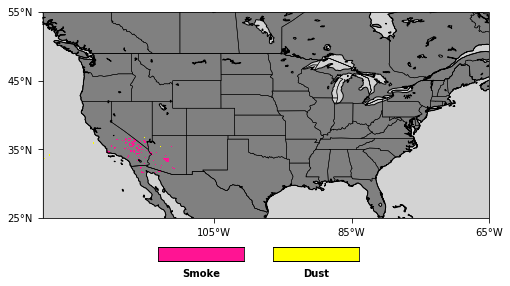

JRR-ADP_j01_2020-11-05_21:24:42


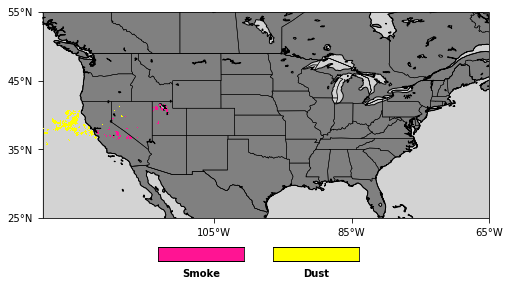

JRR-ADP_j01_2020-11-05_21:24:42


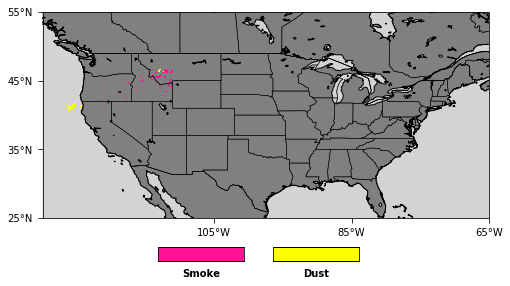

JRR-ADP_j01_2020-11-05_21:24:42


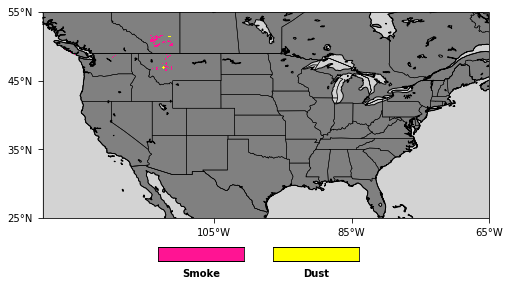

JRR-ADP_j01_2020-11-05_21:24:42


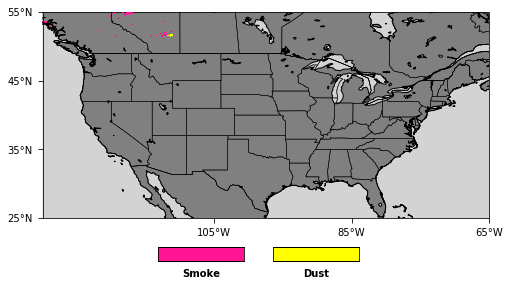

JRR-ADP_j01_2020-11-05_21:24:42
Done!


In [5]:
#Discrete color maps for ABI ADP smoke/dust detection
def adp_color_maps():
    smoke_color_map = mpl.colors.ListedColormap(['deeppink'])
    dust_color_map = mpl.colors.ListedColormap(['yellow'])
    
    return smoke_color_map, dust_color_map


#Create smoke/dust detection colorbars, independent of plotted data, auto-positioning
#cbar_ax are dummy variables
#Location/dimensions of colorbar set by .set_position (x0, y0, width, height) to scale automatically with plot
def adp_colorbars(fig, ax):
    last_axes = plt.gca()
    cbar1_ax = fig.add_axes([0, 0, 0, 0])
    cbar2_ax = fig.add_axes([0.1, 0.1, 0.1, 0.1])
    plt.draw()
    posn = ax.get_position()
    cbar1_ax.set_position([0.325, posn.y0 - 0.06, 0.15, 0.02])
    cbar2_ax.set_position([0.525, posn.y0 - 0.06, 0.15, 0.02])
    smoke_color_map, dust_color_map = adp_color_maps()
    norm = mpl.colors.Normalize(vmin = 0.5, vmax = 1.5)
    cb1 = mpl.colorbar.ColorbarBase(cbar1_ax, cmap = smoke_color_map, norm = norm, orientation = 'horizontal', ticks = [0.5, 1.5])
    cb1.set_label(label = 'Smoke', size = 10, weight = 'bold')
    cb1.ax.xaxis.set_major_formatter(ticker.NullFormatter())
    cb1.ax.tick_params(which = 'major', length = 0)
    cb2 = mpl.colorbar.ColorbarBase(cbar2_ax, cmap = dust_color_map, norm = norm, orientation = 'horizontal', ticks = [0.5, 1.5])
    cb2.set_label(label = 'Dust', size = 10, weight = 'bold')
    cb2.ax.xaxis.set_major_formatter(ticker.NullFormatter())
    cb2.ax.tick_params(which = 'major', length = 0)
    plt.sca(last_axes)
    
    
#Format map with lat/lon grid, coastlines/borders (Plate Carree projection)
def map_settings(ax):
    #Set up and label the lat/lon grid
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xticks(lon_ticks, crs = ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs = ccrs.PlateCarree())
    
    #Set lat/lon ticks and gridlines
    ax.tick_params(length = 5, direction = 'out', labelsize = 10, pad = 5)
    ax.grid(linewidth = 0.5, zorder = 3)
   
    #Draw coastlines/borders using Cartopy; zorder sets drawing order for layers
    ax.coastlines(resolution = '50m', zorder = 3)
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'ocean', scale = '50m'), facecolor = 'lightgrey')
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'land', scale = '50m'), facecolor = 'grey')
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'lakes', scale = '50m'), facecolor = 'lightgrey', edgecolor = 'black', zorder = 2)
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'cultural', name = 'admin_0_countries', scale = '50m'), facecolor = 'none', lw = 0.5, edgecolor = 'black', zorder = 3)
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'cultural', name = 'admin_1_states_provinces', scale = '50m'), facecolor = 'none', lw = 0.5, edgecolor = 'black', zorder = 3)
    
    #Set domain for map [x0, x1, y0, y1]
    ax.set_extent(domain, crs = ccrs.PlateCarree())


#Function to plot ABI ADP smoke/dust detection - Plate Carree projection
def plot_abi_adp(file_id, save=False):

    #Set up figure and map projection: PlateCarree(central_longitude)
    #Plate Carree: equidistant cylindrical projection w/equator as the standard parallel; default central_longitude = 0
    fig = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree())

    #Select and process smoke and dust ADP data
    smoke_final, dust_final, lat, lon = VIIRS_ADP_Detect(file_id)

    #Format map
    map_settings(ax)

    #Colormaps for plotting ADP data
    smoke_color_map, dust_color_map = adp_color_maps()

    #Add ADP colorbars
    adp_colorbars(fig, ax)
    
    #Create filled contour plots of smoke and dust data
    try:
        ax.contourf(lon, lat, smoke_final, levels = [0.5, 1.5, 3], cmap = smoke_color_map, zorder = 3, transform = ccrs.PlateCarree())
    except:
        pass
    try:
        ax.contourf(lon, lat, dust_final, levels = [0.5, 1.5, 3], cmap = dust_color_map, zorder = 3, transform = ccrs.PlateCarree()) 
    except:
        pass

    #Show figure
    plt.show()

    #Save figure as a .png file to specified subdirectory
    fname_attr = fname.split("_")
    
#     date = datetime.datetime.strptime(fname[-49:-42], '%Y%j').date().strftime('%Y%m%d')
    date = datetime.datetime.strptime(fname_attr[3][1:-1], '%Y%m%d%H%M%S')
    filename = "_".join([fname_attr[0], fname_attr[2], date.strftime("%Y-%m-%d_%H:%M:%S")])
#     filename = 'G' + fname[-53:-51] + + date + '_' + fname[-42:-38]
    if save:
        fig.savefig(save_path + filename, bbox_inches = 'tight', dpi = file_res)
    
    print(filename)
    #Close file
    file_id.close()
    
    #Erase plot so we can build the next one
    plt.close()    

#####################################################################################   
#Plot ABI ADP data on Plate Carree projection

#Plot settings
file_res = 150  #dpi setting for image resolution
figures = 'multiple'  #number of figures to create: 'single' or 'multiple'

#File settings
file_path = 'JRR-ADP_v2r3_j01_s202011052124420_e202011052134393_c202011052205170/'  #location of data files
# file_name = 'JRR-ADP_v2r3_npp_s202010131927595_e202010131929237_c202010132005370.nc' #for single file
# save_path = 'D://Data/2020/2020-09/20200914/Figures/'  #location for saved figures

#Mapping settings
#Use 180 degrees for longitude (i.e, 100 degrees W = -100)
domain = [-130, -65, 25, 55]
lon_ticks = [-105, -85, -65]
lat_ticks = [25, 35, 45, 55]


if figures == 'single':
    #Open single data file and set file name
    fname = file_path + file_name
    file_id = Dataset(fname)
    print(file_id)
    plot_abi_adp(file_id)
    print('Done!')

if figures == 'multiple':
    #Collect all of the .nc files in given subdirectory
    file_list = sorted(glob.glob(file_path + '*.nc')) 
    #Loop through data files, making/saving a figure for each data file
    for fname in file_list:
        file_id = Dataset(fname)
        plot_abi_adp(file_id)
    print('Done!')